# **Exploratory Data Analysis & Data Preprocessing**

## About the dataset:

* Large IMDB Movie Review Dataset: 

This is a dataset for binary sentiment classification containing substantially more data than previous benchmark datasets. We provide a set of 25,000 highly polar movie reviews for training, and 25,000 for testing. 
* Paper References:
https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf 
* It consists of 2 columns, namely review and sentiment.
* **Review** column consists of the large movie reviews for various movies
* **Sentiment** column contains the user sentiment as deciphered from the review, which can be **positive** or **negative**. 


In [ ]:
## Importing Packages

import pandas as pd
import numpy as np
import json, re
from tqdm import tqdm_notebook
from uuid import uuid4
import textwrap
from tqdm.auto import tqdm

## Plotting packages
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap
import itertools
import collections

## NLP packages
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS
import spacy

## Torch Modules
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader

In [ ]:
# Initializing Spacy ‘en’ model, keeping only the component need for lemmatization and creating an engine. 

nlp = spacy.load('en', disable=['parser', 'ner'])

In [ ]:
# Mount GDrive to load dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Reading in the IMDB Reviews dataset

path = '/content/drive/MyDrive/MMD-Project-IMDB-Sentiment-Analysis'
df = pd.read_csv(path+'/IMDB_Dataset.csv', encoding='latin-1')
df

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49995,I thought this movie did a down right good job...,positive
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,I am a Catholic taught in parochial elementary...,negative
49998,I'm going to have to disagree with the previou...,negative


In [ ]:
# Analysis of how many positive and negative reviews are present in the dataset

print("Total number of movie reviews:\n",df.count())
print("\nPositive movie reviews:\n", df[df['sentiment'] == 'positive'].count())
print("\nNegative movie reviews:\n", df[df['sentiment'] == 'negative'].count())

Total number of movie reviews:
 review       50000
sentiment    50000
dtype: int64

Positive movie reviews:
 review       25000
sentiment    25000
dtype: int64

Negative movie reviews:
 review       25000
sentiment    25000
dtype: int64


## 1. Converting to lowercase

In [ ]:
# Transform all the reviews in 'review' column into lower case and create a new column 'new_reviews'.

df['new_reviews'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['new_reviews'].head()

0    one of the other reviewers has mentioned that ...
1    a wonderful little production. <br /><br />the...
2    i thought this was a wonderful way to spend ti...
3    basically there's a family where a little boy ...
4    petter mattei's "love in the time of money" is...
Name: new_reviews, dtype: object

## 2. Remove punctuations

In [ ]:
# Next, the punctuation is removed

df['new_reviews'] = df['new_reviews'].str.replace('[^\w\s]','')
df['new_reviews'].head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  This is separate from the ipykernel package so we can avoid doing imports until


0    one of the other reviewers has mentioned that ...
1    a wonderful little production br br the filmin...
2    i thought this was a wonderful way to spend ti...
3    basically theres a family where a little boy j...
4    petter matteis love in the time of money is a ...
Name: new_reviews, dtype: object

## 3. Remove emojis, if any

In [ ]:
# Remove emojis, if any are present as they may be hard to interpret by the model

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags 
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

df['new_reviews'] = df['new_reviews'].apply(lambda x: remove_emoji(x))
df

,review,sentiment,new_reviews
0,One of the other reviewers has mentioned that ...,positive,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,positive,a wonderful little production br br the filmin...
2,I thought this was a wonderful way to spend ti...,positive,i thought this was a wonderful way to spend ti...
3,Basically there's a family where a little boy ...,negative,basically theres a family where a little boy j...
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive,petter matteis love in the time of money is a ...
...,...,...,...
49995,I thought this movie did a down right good job...,positive,i thought this movie did a down right good job...
49996,"Bad plot, bad dialogue, bad acting, idiotic di...",negative,bad plot bad dialogue bad acting idiotic direc...
49997,I am a Catholic taught in parochial elementary...,negative,i am a catholic taught in parochial elementary...
49998,I'm going to have to disagree with the previou...,negative,im going to have to disagree with the previous...


## 4. Remove stopwords

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
# After some transformations, the reviews are much cleaner, but we still have some words that we should remove, namely the stopwords. 
# Stopwords are commonly used words (i.e. “the”, “a”, “and”) that do not add meaning to a sentence and can be ignored without having a drastic 
# effect on the meaning of the sentence.

stop = stopwords.words('english')
df['new_reviews'] = df['new_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))


In [ ]:
pd.set_option('display.max_colwidth', None)
df.head()

,review,sentiment,new_reviews
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,one reviewers mentioned watching 1 oz episode youll hooked right exactly happened mebr br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthats get touch darker side
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",positive,wonderful li

In [ ]:
# Analysing text size - for better prediction of tokenization batch size

print("Average text length of the movie review: ",df['review'].str.len().mean())
print("Maximum text length of the movie review: ",df['review'].str.len().max())
print("Minimum text length of the movie review: ",df['review'].str.len().min())

Average text length of the movie review:  1309.67016
Maximum text length of the movie review:  13704
Minimum text length of the movie review:  32


In [ ]:
print("Average text length of the movie review: ",df['new_reviews'].str.len().mean())
print("Maximum text length of the movie review: ",df['new_reviews'].str.len().max())
print("Minimum text length of the movie review: ",df['new_reviews'].str.len().min())

Average text length of the movie review:  846.7544
Maximum text length of the movie review:  9334
Minimum text length of the movie review:  17


- As we can see above, average text lengths of the movie reviews before preprocessing are longer - 13,704 whereas average lengths after preprocessing are shorter - 9334. This shows how much removing punctuations and stopwords helps our model. 

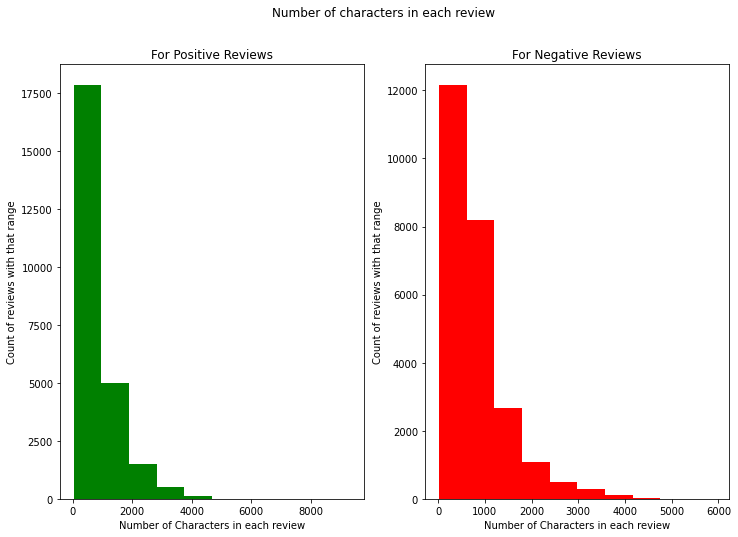

In [ ]:
# Number of characters in positive reviews and negative reviews 

positive_data = df[df.sentiment == 'positive']['new_reviews']
negative_data = df[df.sentiment == 'negative']['new_reviews']
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('For Positive Reviews')
ax1.set_xlabel('Number of Characters in each review')
ax1.set_ylabel('Count of reviews with that range')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('For Negative Reviews')
ax2.set_xlabel('Number of Characters in each review')
ax2.set_ylabel('Count of reviews with that range')
fig.suptitle('Number of characters in each review')
plt.show()

- From the above graph, we can see that positive reviews have a larger number of characters (17500) as compared to negative (12000). However, there are more negative reviews with a larger number of characters (in the range of 0-2000) as compared to positive. 

## 5. Checking for duplicates & NULL values

In [ ]:
# Next, we are checking for presence of NULL values and dropping duplicates values that cause redundancy

duplicate_rows = df[df.duplicated()]
print("Number of duplicate rows in the dataset: ", len(duplicate_rows))

Number of duplicate rows in the dataset:  418


In [ ]:
df = df.drop_duplicates()

In [ ]:
print("Total number of movie reviews:\n",df.count())
print("\nPositive movie reviews:\n", df[df['sentiment'] == 'positive'].count())
print("\nNegative movie reviews:\n", df[df['sentiment'] == 'negative'].count())

Total number of movie reviews:
 review         49582
sentiment      49582
new_reviews    49582
dtype: int64

Positive movie reviews:
 review         24884
sentiment      24884
new_reviews    24884
dtype: int64

Negative movie reviews:
 review         24698
sentiment      24698
new_reviews    24698
dtype: int64


- In comparison to the number of rows in our dataset before the preprocessing, we have around 500 rows lesser in both positive and negative reviews. 

In [ ]:
# there are no NULL values present in the data

df1 = df[df.isna().any(axis=1)]
df1 

,review,sentiment,new_reviews


## 6. Checking if the dataset is balanced

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Sentiment')

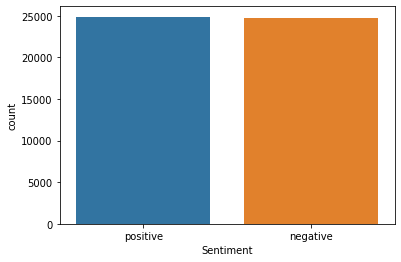

In [ ]:
# the distribution of both reviews is quite balanced

sns.countplot(df.sentiment)
plt.xlabel('Sentiment')

In [ ]:
df1 = df.copy(deep=True)

## 7. Lemmatization

Lemmatization: 

Lastly, we will implement lemmatization using Spacy so that we can count the appearance of each word. 
Lemmatization removes the grammar tense and transforms each word into its original form. 
Another way of converting words to its original form is called stemming. While stemming takes the linguistic root of a word, lemmatization is taking a word into its original lemma. For example, if we performed stemming on the word “apples”, the result would be “appl”, whereas lemmatization would give us “apple”. Therefore I prefer lemmatization over stemming, as its much easier to interpret.


In [ ]:
import nltk
nltk.download('wordnet')
nltk.download('punkt')
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]

In [ ]:
df1['lemmatized_tokens'] = df1['new_reviews'].apply(lemmatize_text)
df1

,review,sentiment,new_reviews,lemmatized_tokens
0,"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",positive,one reviewers mentioned watching 1 oz episode youll hooked right exactly happened mebr br first thing struck oz brutality unflinching scenes violence set right word go trust show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use wordbr br called oz nickname given oswald maximum security state penitentary focuses mainly emerald city experimental section prison cells glass fronts face inwards privacy high agenda em city home manyaryans muslims gangstas latinos christians italians irish moreso scuffles death stares dodgy dealings shady agreements never far awaybr br would say main appeal show due fact goes shows wouldnt dare forget pretty pictures painted mainstream audiences forget charm forget romanceoz doesnt mess around first episode ever saw struck nasty surreal couldnt say ready watched developed taste oz got accustomed high levels graphic violence violence injustice crooked guards wholl sold nickel inmates wholl kill order get away well mannered middle class inmates turned prison bitches due lack street skills prison experience watching oz may become comfortable uncomfortable viewingthats get touch darker side,"[one, reviewer, mentioned, watching, 1, oz, episode, youll, hooked, right, exactly, happened, mebr, br, first, thing, struck, oz, brutality, unflinching, scene, violence, set, right, word, go, trust, show, faint, hearted, timid, show, pull, punch, regard, drug, sex, violence, hardcore, classic, use, wordbr, br, called, oz, nickname, given, oswald, maximum, security, state, penitentary, focus, mainly, emerald, city, experimental, section, prison, cell, glass, front, face, inwards, privacy, high, agenda, em, city, home, manyaryans, muslim, gangsta, latino, christian, italian, irish, moreso, scuffle, death, stare, dodgy, dealing, shady, agreement, never, far, awaybr, br, would, say, main, appeal, show, due, fact, go, show, wouldnt, dare, ...]"
1,"A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- M

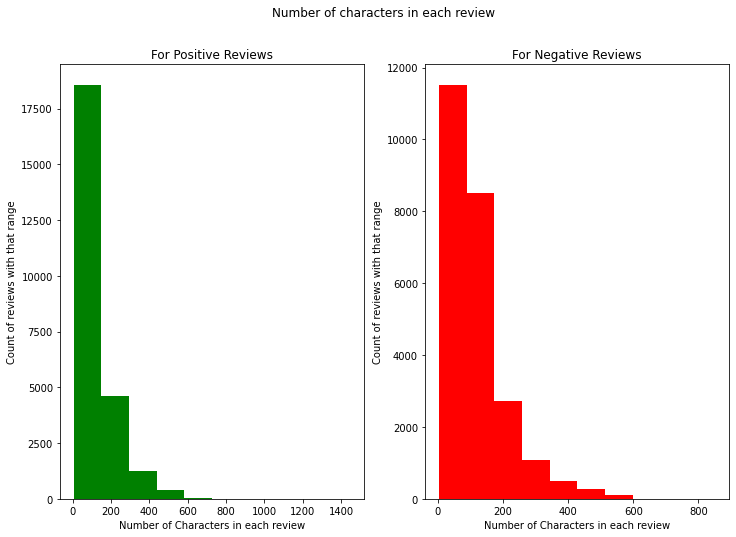

In [ ]:
# Number of characters in positive reviews and negative reviews after applying preprocessing techniques

positive_data = df1[df1.sentiment == 'positive']['lemmatized_tokens']
negative_data = df1[df1.sentiment == 'negative']['lemmatized_tokens']
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(12,8))
text_len=positive_data.str.len()
ax1.hist(text_len,color='green')
ax1.set_title('For Positive Reviews')
ax1.set_xlabel('Number of Characters in each review')
ax1.set_ylabel('Count of reviews with that range')
text_len=negative_data.str.len()
ax2.hist(text_len,color='red')
ax2.set_title('For Negative Reviews')
ax2.set_xlabel('Number of Characters in each review')
ax2.set_ylabel('Count of reviews with that range')
fig.suptitle('Number of characters in each review')
plt.show()

## 8. Finding most frequent words in reviews

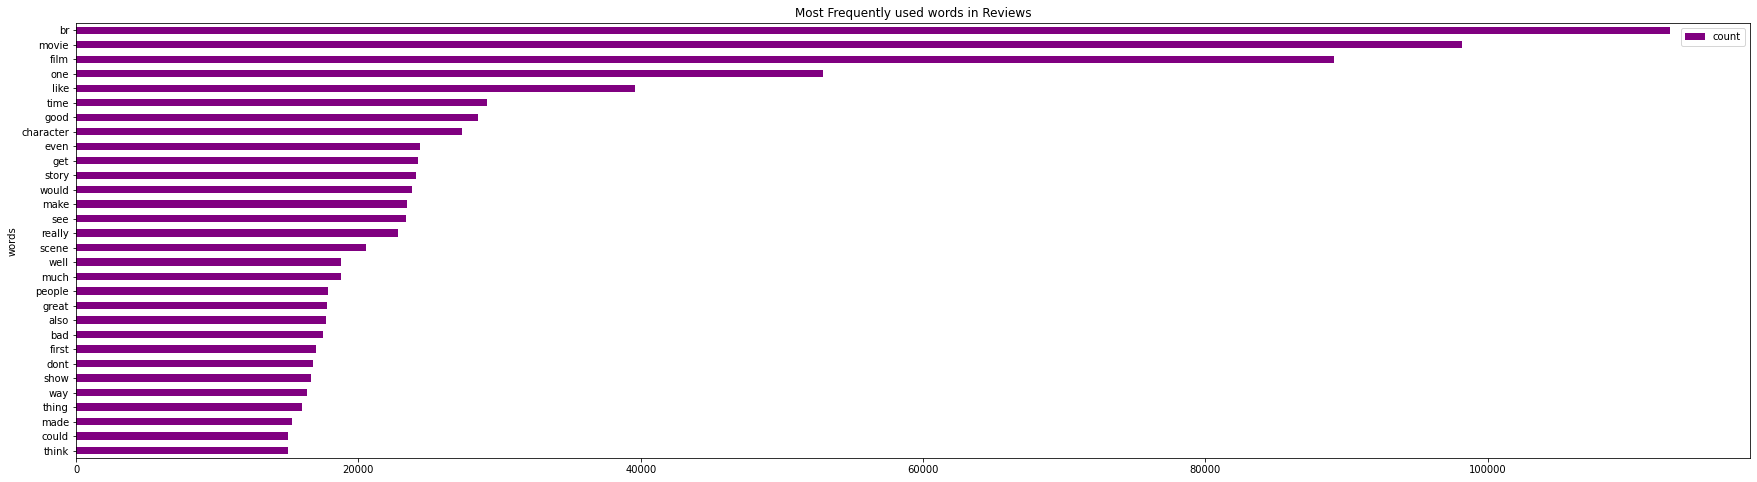

In [ ]:
# We are also interested in the most frequent words other than the stopwords but highly frequent in reviews. 

def plot(df):
  lemmatized_tokens = list(df["lemmatized_tokens"])
  token_list = list(itertools.chain(*lemmatized_tokens))
  counts_no = collections.Counter(token_list)
  clean_reviews = pd.DataFrame(counts_no.most_common(30),
                              columns=['words', 'count'])
  fig1, ax = plt.subplots(figsize=(30, 8))
  clean_reviews.sort_values(by='count').plot.barh(x='words',
                         y='count',
                         ax=ax,
                         color="purple")
  
  ax.set_title("Most Frequently used words in Reviews")

plot(df1)

## 9. Finding most frequent bigrams

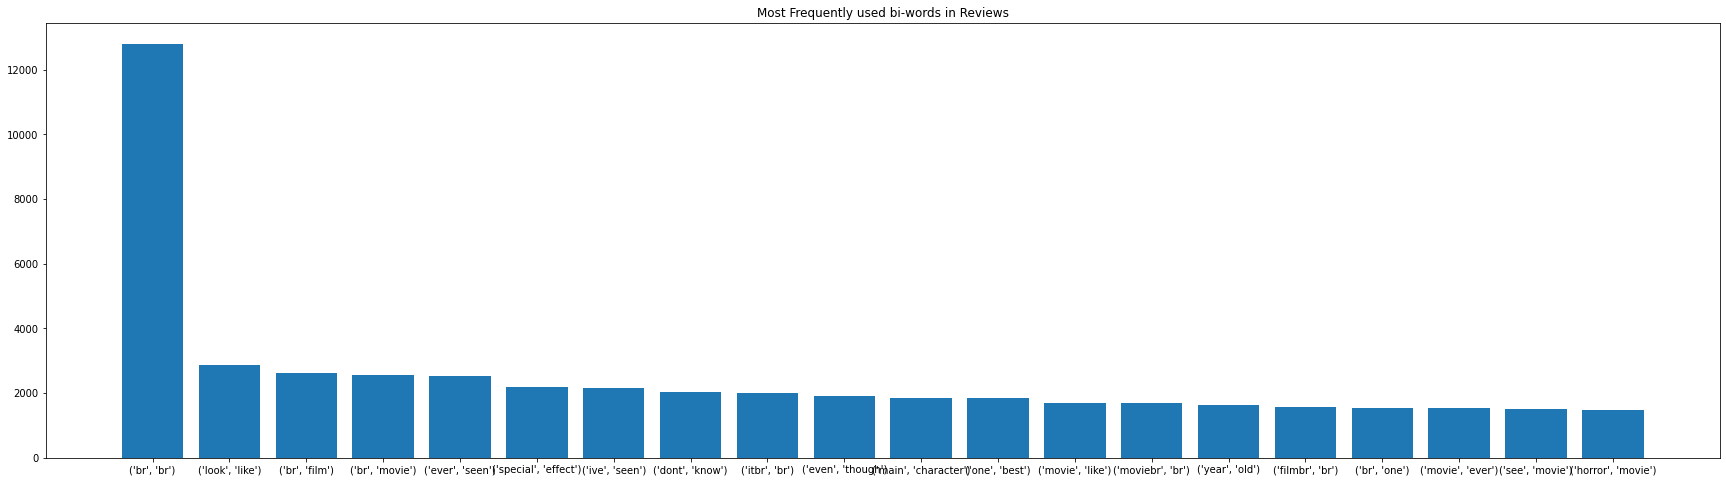

In [ ]:
# A bigram is a sequence of two adjacent elements from a string of tokens, typically letters, syllables, or words. 
# We also check the highly frequent bigrams in our data to better understand most frequently used words. 

def plot2(df):
  lemmatized_tokens = list(df["lemmatized_tokens"])
  token_list = list(itertools.chain(*lemmatized_tokens))
  bigrams = zip(token_list, token_list[1:])
  counts_no = collections.Counter(bigrams)

  y = [count for tag, count in counts_no.most_common(20)]
  x = [tag for tag, count in counts_no.most_common(20)]

  fig2,ax = plt.subplots(figsize=(30, 8))
  ax.bar(range(len(y)),y)
  ax.set_xticks(range(len(y)))
  ax.set_xticklabels([str(item) for item in x])
  ax.set_title("Most Frequently used bi-words in Reviews")
plot2(df1)

This shows some good results on which words are most frequently used. 

We can ignore the words like 'movie', 'film', 'br'(HTML break) which do not add value to the sentiment analysis, thereby reducing our data size to a considerable extent.



In [ ]:
df3 = df.copy(deep=True)

In [ ]:
# Remove these unneccessary words
remove_list = ['br','movie','film','one']
df3['new_reviews'] = df3['new_reviews'].apply(lambda x: " ".join(x for x in x.split() if x not in remove_list))

In [ ]:
df3['lemmatized_tokens'] = df3['new_reviews'].apply(lemmatize_text)

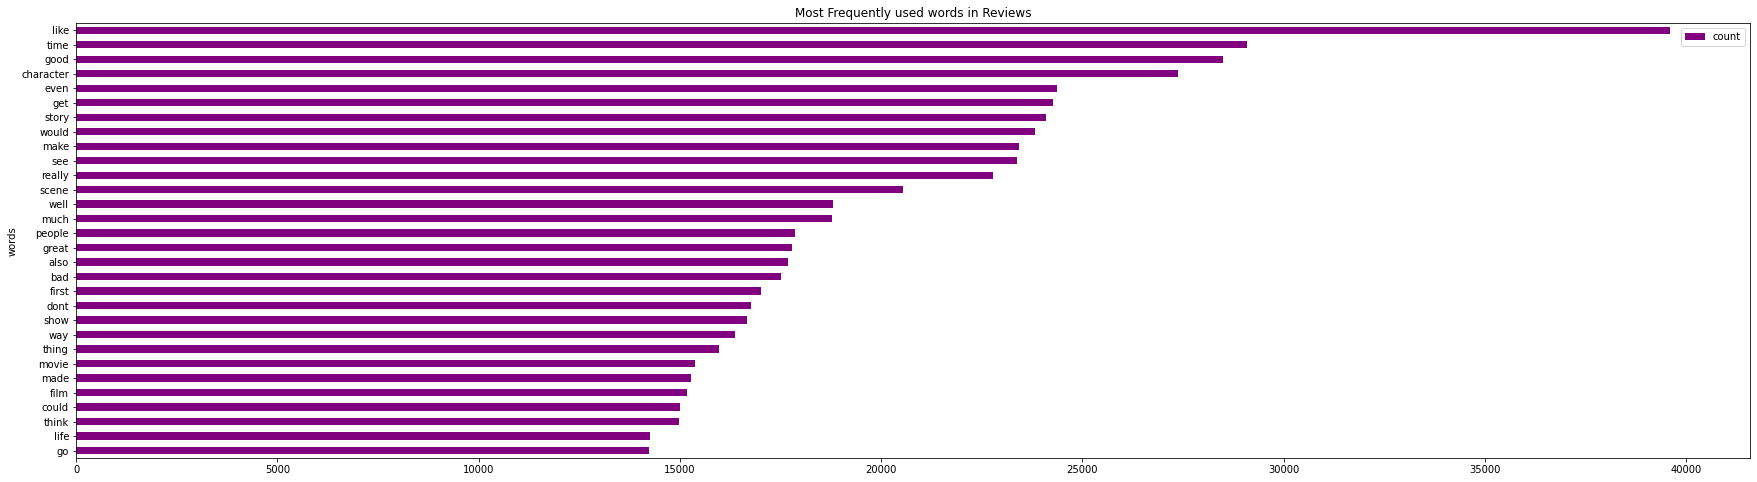

In [ ]:
plot(df3)

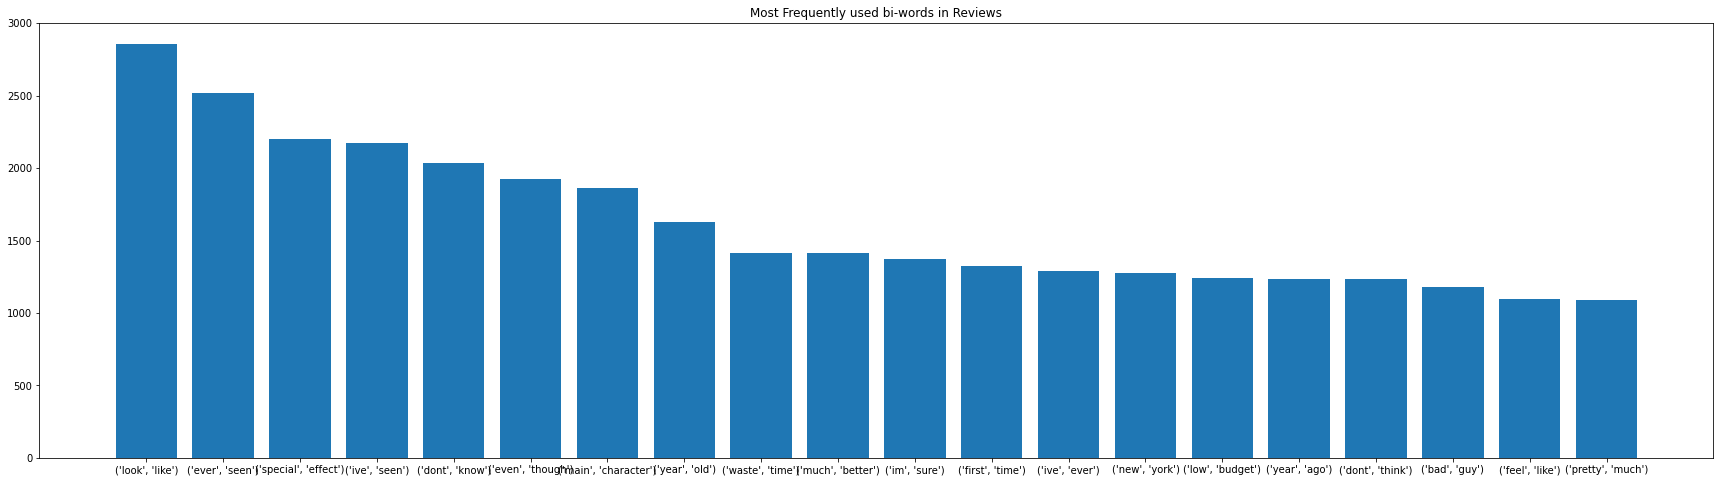

In [ ]:
plot2(df3)

In [ ]:
# Text size before lemmatization

print("Average text length of the movie review: ",df3['review'].str.len().mean())
print("Maximum text length of the movie review: ",df3['review'].str.len().max())
print("Minimum text length of the movie review: ",df3['review'].str.len().min())

Average text length of the movie review:  1310.807853656569
Maximum text length of the movie review:  13704
Minimum text length of the movie review:  32


In [ ]:
# Text size after lemmatization is drastically reduced

print("Average text length of the movie review: ",df3['lemmatized_tokens'].str.len().mean())
print("Maximum text length of the movie review: ",df3['lemmatized_tokens'].str.len().max())
print("Minimum text length of the movie review: ",df3['lemmatized_tokens'].str.len().min())

Average text length of the movie review:  116.49403009156549
Maximum text length of the movie review:  1433
Minimum text length of the movie review:  3


## 10. Word clouds for positive & negative reviews

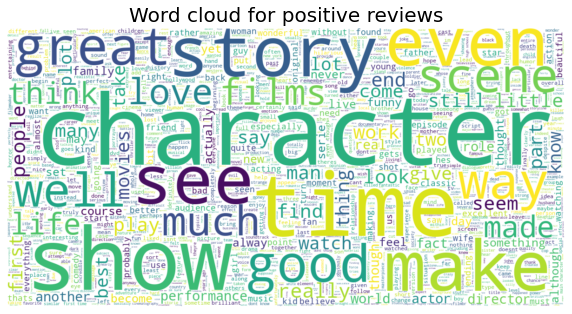

In [ ]:
# word cloud for positive reviews

positive_data = df3[df3.sentiment == 'positive']['new_reviews']
positive_data_string = ' '.join(positive_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(positive_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for positive reviews',fontsize = 20)
plt.show()

World cloud for positive reviews shows that the most commonly used are character, story, time, great, good, etc. 

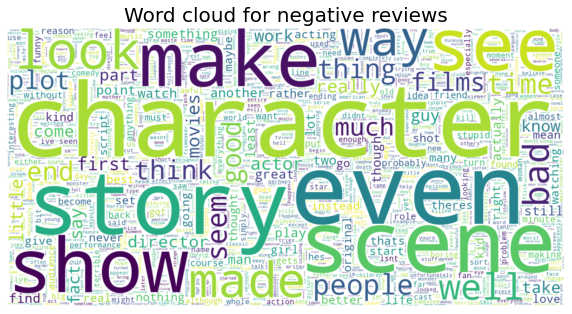

In [ ]:
# word cloud for negative reviews

negative_data = df3[df3.sentiment == 'negative']['new_reviews']
negative_data_string = ' '.join(negative_data)
plt.figure(figsize = (10,10))
wc = WordCloud(max_words = 2000, width=1200, height=600,background_color="white").generate(negative_data_string)
plt.imshow(wc , interpolation = 'bilinear')
plt.axis('off')
plt.title('Word cloud for negative reviews',fontsize = 20)
plt.show()

Word cloud shows that the most commonly used words for writing a negative movie review are character, scene, even, bad, well. 

It is quite interesting to see that character is the most used in both positive negative reviews however depending on the context, it can be construed in a positive or negative connotation.

In [ ]:
output_path = path+ '/eda_output.csv'
with open(output_path, 'w', encoding = 'utf-8-sig') as f:
  df3.to_csv(f)